In [1]:
# import libraries
from cil.optimisation.algorithms import PDHG
from cil.optimisation.functions import L2NormSquared, MixedL21Norm, BlockFunction, IndicatorBox, TotalVariation, ZeroFunction
from cil.optimisation.operators import BlockOperator, GradientOperator, IdentityOperator, SymmetrisedGradientOperator, ZeroOperator
from cil.framework import ImageGeometry, AcquisitionGeometry, AcquisitionData, BlockDataContainer
from cil.plugins.astra.operators import ProjectionOperator
from cil.utilities.display import show2D

import numpy as np
import os, sys

import tomophantom
from tomophantom import TomoP2D

In [2]:
# Load a tomophantom image 
model = 2 # select a model number from the library
N = 128 # set dimension of the phantom
path = os.path.dirname(tomophantom.__file__)
path_library2D = os.path.join(path, "Phantom2DLibrary.dat")

phantom2D_np = TomoP2D.Model(model, N, path_library2D)    
ig = ImageGeometry(voxel_num_x=N, voxel_num_y=N, voxel_size_x = 0.5, voxel_size_y = 0.5)

phantom2D = ig.allocate()
phantom2D.fill(phantom2D_np)

In [3]:
# Create Acquisition Geometry

detectors =  int(np.sqrt(2)*N)
angles = np.linspace(0, np.pi, 180, dtype=np.float32)

ag = AcquisitionGeometry.create_Parallel2D()\
                        .set_angles(angles,angle_unit="radian")\
                        .set_panel(detectors, pixel_size=0.5)

In [4]:
device = "gpu"

In [5]:
# Create Projection Operator
A = ProjectionOperator(ig, ag, device )

In [6]:
# Create projection data and corrupt with noise
np.random.seed(10)

data = A.direct(phantom2D)
noisy_data = ag.allocate()
noisy_data.fill(data.as_array() + np.random.normal(0, 1, ag.shape))

In [7]:
# Regularisation parameters
alpha_tgv = 4
beta = 0.5*alpha_tgv

In [8]:
K11 = GradientOperator(ig)
K12 = IdentityOperator(K11.range)
K22 = SymmetrisedGradientOperator(K11.range)    
K21 = ZeroOperator(ig, K22.range) 
K31 = A
K32 = ZeroOperator(K11.range, ag) 

K = BlockOperator(K11, -K12, K21, K22, K31, K32, shape=(3,2) )   

f1 = alpha_tgv * MixedL21Norm()
f2 = beta * MixedL21Norm() 
f3 = 0.5 * L2NormSquared(b=noisy_data)

F = BlockFunction(f1, f2, f3)         
G = BlockFunction(IndicatorBox(lower=0.0), ZeroFunction())

# Compute operator Norm
normK = K.norm()

# Primal & dual stepsizes
sigma = 1./normK
tau = 1./normK

# Setup and run the PDHG algorithm
pdhg = PDHG(f=F,g=G,operator=K, tau=tau, sigma=sigma,
            max_iteration = 5000,
            update_objective_interval = 500)
pdhg.run(verbose=2)


Initialised GradientOperator with C backend running with  20  threads
PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0       5000         0.000    1.12368e+06  -0.00000e+00    1.12368e+06


/opt/anaconda3/envs/cil21_ep/lib/python3.8/site-packages/cil/framework/framework.py:2185: RuntimeWarning: invalid value encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )


      500       5000         0.043    2.53178e+04   1.85248e+04    6.79306e+03
     1000       5000         0.034    2.41483e+04   1.93032e+04    4.84508e+03
     1500       5000         0.031    2.36452e+04   1.96518e+04    3.99343e+03
     2000       5000         0.030    2.32124e+04   1.98920e+04    3.32038e+03
     2500       5000         0.029    2.27390e+04   2.00243e+04    2.71473e+03
     3000       5000         0.029    2.24153e+04   2.01177e+04    2.29755e+03
     3500       5000         0.028    2.21946e+04   2.01868e+04    2.00780e+03
     4000       5000         0.028    2.20138e+04   2.02377e+04    1.77604e+03
     4500       5000         0.027    2.18658e+04   2.02853e+04    1.58047e+03
     5000       5000         0.027    2.16826e+04   2.03153e+04    1.36727e+03
----------------------------------------------------------------------------
     5000       5000         0.027    2.16826e+04   2.03153e+04    1.36727e+03
Stop criterion has been reached.



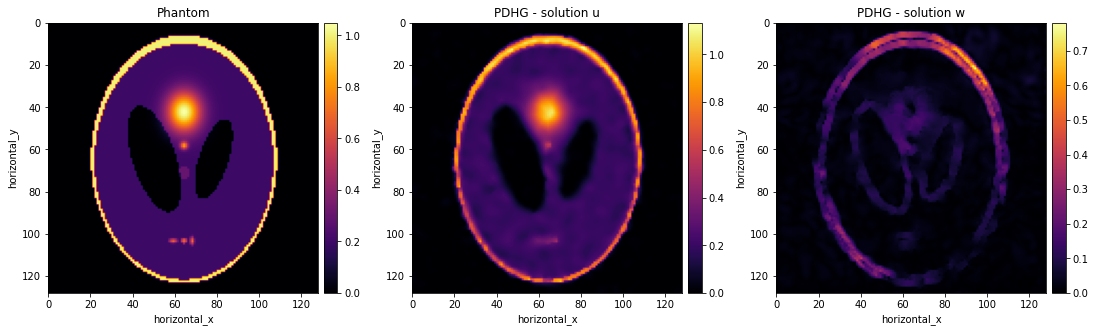

In [10]:
show2D([phantom2D, pdhg.solution.get_item(0), pdhg.solution.get_item(1).pnorm(2)],
          title=["Phantom", "PDHG - solution u","PDHG - solution w"],
         origin = "upper", cmap="inferno", num_cols=3)